# HW 4: Variational Autoencoders

In [1]:
USE_CUDA = True

In this homework you will build a deep generative model of binary images (MNIST) using variational autoencoders and generative adversarial networks.
The original VAE paper can be found [here](https://arxiv.org/abs/1312.6114) and GANs [here](https://arxiv.org/abs/1406.2661), and there are many excellent tutorials
online, e.g. [here](https://arxiv.org/abs/1606.05908) and [here](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)

**For this homework there will not be a Kaggle submission**

## Goals


1. Build a discrete deep generative model of binary digits (MNIST) using variational autoencoders
2. Examine the learned latent space with visualizations 
3. Build a continuous deep generative model using generative adversarial networks.
4. Additionally extend the above in any way, for example by :
    - using better encoder/decoders (e.g. CNN as the encoder, PixelCNN as the decoder. Description of PixelCNN 
    can be found [here](https://arxiv.org/abs/1601.06759))
    - using different variational families, e.g. with [normalizing flows](https://arxiv.org/abs/1505.05770), 
    [inverse autoregressive flows](https://arxiv.org/pdf/1606.04934.pdf), 
    [hierarchical models](https://arxiv.org/pdf/1602.02282.pdf)
    - comparing with stochastic variational inference (i.e. where your variational parameters are randomly initialized and
    then updated with gradient ascent on the ELBO
    - or your own extension.

For your encoder/decoder, we suggest starting off with simple models (e.g. 2-layer MLP with ReLUs).

Consult the papers provided for hyperparameters, and the course notes for formal definitions.


## Setup

This notebook provides a working definition of the setup of the problem itself. Feel free to construct your models inline, or use an external setup (preferred) to build your system.

First, as always, let's download the data.

In [2]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
train_dataset = datasets.MNIST(root='./data/',
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = datasets.MNIST(root='./data/',
                           train=False, 
                           transform=transforms.ToTensor())

In [3]:
print(len(train_dataset))
print(len(test_dataset))

60000
10000


By default MNIST gives grayscale values between [0,1]. Since we are modeling binary images, we have to turn these
into binary values, i.e. $\{0,1\}^{784}$). A standard way to do this is to interpret the grayscale values as 
probabilities and sample Bernoulli random vectors based on these probabilities. (Note you should not do this for GANs)


In [4]:
torch.manual_seed(3435)
train_img = torch.stack([torch.bernoulli(d[0]) for d in train_dataset])
train_label = torch.LongTensor([d[1] for d in train_dataset])
test_img = torch.stack([torch.bernoulli(d[0]) for d in test_dataset])
test_label = torch.LongTensor([d[1] for d in test_dataset])

MNIST does not have an official train dataset. So we will use the last 10000 training points as your validation set.

In [5]:
val_img = train_img[-10000:].clone()
val_label = train_label[-10000:].clone()
train_img = train_img[:-10000]
train_label = train_label[:-10000]

Now we use the dataloader to split into batches.

In [6]:
train = torch.utils.data.TensorDataset(train_img, train_label)
val = torch.utils.data.TensorDataset(val_img, val_label)
test = torch.utils.data.TensorDataset(test_img, test_label)
BATCH_SIZE = 100
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

In [8]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, encoder, decoder, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim
    
    def forward(self, batch):
        batch_size = batch.size(0) 
        means, log_vars = self.encoder(batch)
        Z = Variable(torch.normal(means=torch.zeros(batch_size, self.latent_dim), 
                                  std=torch.ones(batch_size, self.latent_dim)))
        if USE_CUDA:
            Z = Z.cuda()
        latent_samps = means + Z * torch.exp(1/2 * log_vars)
        probs = self.decoder(latent_samps)
        return probs, means, log_vars

In [9]:
class MLPEncoder(nn.Module):
    def __init__(self, latent_dim, hid_layer_dim):
        super(MLPEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.hid_layer_dim = hid_layer_dim
        self.linear1 = nn.Linear(28 * 28, hid_layer_dim)
        self.linear_mean = nn.Linear(hid_layer_dim, latent_dim)
        self.linear_var = nn.Linear(hid_layer_dim, latent_dim)
    
    def forward(self, batch):
        hidden = F.tanh(self.linear1(batch))
        means = self.linear_mean(hidden)
        log_vars = self.linear_var(hidden)
        return means, log_vars
    
class MLPDecoder(nn.Module):
    def __init__(self, latent_dim, hid_layer_dim):
        super(MLPDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.hid_layer_dim = hid_layer_dim
        self.linear1 = nn.Linear(latent_dim, hid_layer_dim)
        self.linear2 = nn.Linear(hid_layer_dim, 28 * 28)
    
    def forward(self, latent_samps):
        hidden = F.tanh(self.linear1(latent_samps))
        probs = F.sigmoid(self.linear2(hidden))
        log_probs = torch.stack([torch.log(1-probs), torch.log(probs)], dim=2)
        return log_probs

In [10]:
def loss(img, log_probs, means, log_vars):
    rec_loss = -torch.gather(log_probs, dim=2, index=img.long().unsqueeze(dim=2)).squeeze()
    rec_loss = rec_loss.sum(dim=1)
    reg_loss = -1/2 * torch.sum(1 + log_vars - means**2 - torch.exp(log_vars), dim=1)
    avg_loss = rec_loss.mean() + reg_loss.mean()
    return avg_loss

In [11]:
def evaluate(model, data):
    model.eval()
    data_loss = 0
    data_size = 0
    for datum in data:
        img, label = datum
        img = img.squeeze().view(data.batch_size, -1)
        img = Variable(img)
        if USE_CUDA:
            img = img.cuda()

        log_probs, means, log_vars = vae(img)
        avg_loss = loss(img, log_probs, means, log_vars)
        data_size += img.size(0)
        data_loss += avg_loss * img.size(0)
    model.train()
    return data_loss / data_size

In [12]:
def train(model, data, optimizer):
    model.train()
    data_loss = 0
    data_size = 0
    for datum in data:
        img, label = datum
        img = img.squeeze().view(data.batch_size, -1)
        img = Variable(img)
        if USE_CUDA:
            img = img.cuda()

        model.zero_grad()
        log_probs, means, log_vars = model(img)
        avg_loss = loss(img, log_probs, means, log_vars)
        if USE_CUDA:
            avg_loss = avg_loss.cuda()
        avg_loss.backward()
        optimizer.step()
        
        data_size += img.size(0)
        data_loss += avg_loss * img.size(0)
    return data_loss / data_size

In [214]:
LATENT_DIM = 2
HID_LAYER_DIM = 500 
N_EPOCHS = 200

In [215]:
enc = MLPEncoder(LATENT_DIM, HID_LAYER_DIM)
dec = MLPDecoder(LATENT_DIM, HID_LAYER_DIM)
vae = VariationalAutoencoder(enc, dec, LATENT_DIM)
if USE_CUDA == True:
    vae = vae.cuda()
optimizer = optim.Adagrad(vae.parameters(), lr=0.01)

In [216]:
# Initialize weights
for p in vae.parameters():
    p = p.data.normal_(mean=0, std=0.01)

# Train model
for i in range(N_EPOCHS):
    train_loss = train(vae, train_loader, optimizer).data[0]
    val_loss = evaluate(vae, train_loader).data[0]
    if (i % 5 == 0) | (i == N_EPOCHS - 1):
        print('| Epoch #{:3d} | train loss {:5.4f} | val loss {:5.4f}'.format(i, train_loss, val_loss))

| Epoch #  0 | train loss 200.8404 | val loss 184.9219
| Epoch #  5 | train loss 179.1859 | val loss 178.9228
| Epoch # 10 | train loss 177.8932 | val loss 177.6882
| Epoch # 15 | train loss 176.3204 | val loss 176.1263
| Epoch # 20 | train loss 174.9512 | val loss 174.7990
| Epoch # 25 | train loss 173.9862 | val loss 173.8850
| Epoch # 30 | train loss 173.0535 | val loss 172.9339
| Epoch # 35 | train loss 171.9424 | val loss 171.7760
| Epoch # 40 | train loss 170.6614 | val loss 170.5191
| Epoch # 45 | train loss 169.3812 | val loss 169.2548
| Epoch # 50 | train loss 168.2402 | val loss 168.1010
| Epoch # 55 | train loss 167.2570 | val loss 167.1341
| Epoch # 60 | train loss 166.4557 | val loss 166.3569
| Epoch # 65 | train loss 165.7703 | val loss 165.6403
| Epoch # 70 | train loss 165.1553 | val loss 165.0625
| Epoch # 75 | train loss 164.6252 | val loss 164.5459
| Epoch # 80 | train loss 164.1210 | val loss 164.1215
| Epoch # 85 | train loss 163.6790 | val loss 163.6046
| Epoch # 

## Visualizations

In [217]:
import seaborn
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()
%matplotlib inline

In [218]:
all_means = []
all_labels = []
for datum in val_loader:
    img, label = datum
    img = img.squeeze().view(val_loader.batch_size, -1)
    img = Variable(img)
    if USE_CUDA:
        img = img.cuda()

    log_probs, means, log_vars = vae(img)
    all_means.append(means)
    all_labels.append(label)
all_means = torch.cat(all_means).data.cpu().numpy()
all_labels = torch.cat(all_labels).cpu().numpy()

In [219]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'violet', 'orange']

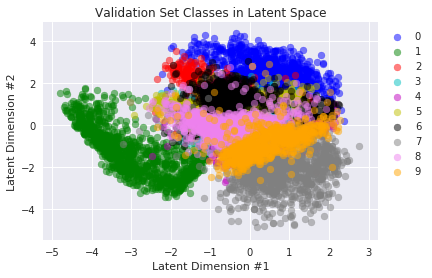

In [220]:
plt.title('Validation Set Classes in Latent Space')
plt.xlabel('Latent Dimension #1')
plt.ylabel('Latent Dimension #2')
for i in range(10):
    points = all_means[all_labels == i]
    plt.scatter(points[:, 0], points[:, 1], c=colors[i], alpha=0.5)
plt.legend(range(10), bbox_to_anchor=(1, 1))

In [230]:
N_POINTS_PER_DIM = 10
x1_grid = np.linspace(2, -2, N_POINTS_PER_DIM)
x2_grid = np.linspace(-2, 2, N_POINTS_PER_DIM)
dim1_grid, dim2_grid = np.meshgrid(x1_grid, x2_grid)
dims_grid = torch.FloatTensor(np.stack([dim1_grid, dim2_grid], axis=2))
dims_grid = Variable(dims_grid.view(N_POINTS_PER_DIM**2, 2))
if USE_CUDA:
    dims_grid = dims_grid.cuda()

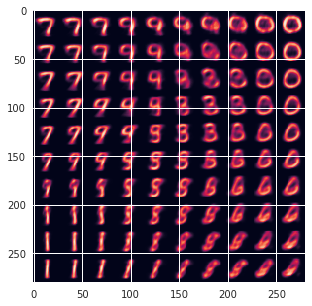

In [231]:
log_probs = vae.decoder(dims_grid).view(N_POINTS_PER_DIM, N_POINTS_PER_DIM, 28, 28, 2)
probs = torch.exp(log_probs)[:, :, :, :, 1]
imgs = probs
imgs = imgs.cuda().cpu().data.numpy()
imgs = np.concatenate(np.concatenate(imgs, axis=2), axis=0)
plt.figure(figsize=(5,5))
plt.imshow(imgs)

Great now we are ready to begin modeling. Performance-wise, you want tune your hyperparameters based on the **evidence lower bound (ELBO)**. Recall that the ELBO is given by:

$$ELBO = \mathbb{E}_{q(\mathbf{z} ; \lambda)} [\log p(\mathbf{x} \,|\,\mathbf{z} ; \theta)] - \mathbb{KL}[q(\mathbf{z};\lambda) \, \Vert \, p(\mathbf{z})]$$

The variational parameters are given by running the encoder over the input, i..e. $\lambda = encoder(\mathbf{x};\phi)$. The generative model (i.e. decoder) is parameterized by $\theta$. Since we are working with binarized digits, $\log p(x \, | \, \mathbf{z} ; \theta)$ is given by:

$$ \log p(x \, | \, \mathbf{z} ; \theta) = \sum_{i=1}^{784} \log \sigma(\mathbf{h})_{i} $$

where $\mathbf{h}$ is the final layer of the generative model (i.e. 28*28 = 784 dimensionval vector), and $\sigma(\cdot)$ is the sigmoid function. 

For the baseline model in this assignment you will be using a spherical normal prior, i.e. $p(\mathbf{z}) = \mathcal{N}(\mathbf{0}, \mathbf{I})$. The variational family will also be normal, i.e. $q(\mathbf{z} ; \lambda) = \mathcal{N}(\boldsymbol{\mu}, \log \boldsymbol \sigma^2)$ (here we will work with normal families with diagonal covariance). The KL-divergence between the variational posterior $q(\mathbf{z})$ and the prior $p(\mathbf{z})$ has a closed-form analytic solution, which is available in the original VAE paper referenced above. (If you are using the torch distributions package they will automatically calculate it for you, however you will need to use pytorch 0.4).

For GANs you should use the same data in its continuous form. Here use the same prior, but use a multi-layer network to map to a continous 28x28 output space. Then use a multilayer discriminator to classify. 

For both models you may also consider trying a deconvolutional network (as in DCGAN) to produce output from the latent variable.

## Visualizations

In addition to quantitative metrics (i.e. ELBO), we are also going to ask you to do some qualitative analysis via visualizations. Please include the following in your report:

1. Generate a bunch of digits from your generative model (sample $\mathbf{z} \sim p(\mathbf{z})$, then $\mathbf{x} \sim p (\mathbf{x} \, | \, \mathbf{z} ; \theta$))
2. Sample two random latent vectors $\mathbf{z}_1, \mathbf{z}_2 \sim p(\mathbf{z})$, then sample from their interpolated values, i.e. $\mathbf{z} \sim p (\mathbf{x} \, | \, \alpha\mathbf{z}_1 + (1-\alpha)\mathbf{z}_2; \theta$) for $\alpha = \{0, 0.2, 0.4, 0.6, 0.8 ,1.0 \}$.
3. Train a VAE with 2 latent dimensions. Make a scatter plot of the variational means, $\mu_1, \mu_2$, where the color
corresponds to the digit.
4. With the same model as in (3), pick a 2d grid around the origin (0,0), e.g. with
`np.meshgrid(np.linspace(-2, 2, 10), np.linspace(-2, 2, 10)`. For each point in the grid $(z_1, z_2)$, generate
$\mathbf{x}$ and show the corresponding digit in the 2d plot. For an example see [here](http://fastforwardlabs.github.io/blog-images/miriam/tableau.1493x693.png) (the right image)
